In [1]:
import pandas as pd
import geopandas as gpd
import json


# I. Converting tab-delimited .txt XL files into CSV for use in Google BigQuery
1. Voter Registration File
2. 2022 Election Results - every State, County, and Munipal Election in 2022 General
3. Voter History Data - each participated election in the past 10 years by a single voter is an indivual entry


### 1. NCSBE Voter Registration Data 
Reading in the complete voter registration file was inefficient and slow, so I used chunks and concatonated

In [2]:
# define input and output paths
voter_registration_input_path = 'data/ncsbe/original/ncvoter_Statewide.txt'
voter_registration_output_path = 'data/ncsbe/processed/ncvoter_statewide.csv'

#read in and process original data from NCSBE in chunks
chunk_size = 10000  
chunks = pd.read_csv(voter_registration_input_path, delimiter='\t', dtype=str, encoding='ISO-8859-1', chunksize=chunk_size)
df = pd.concat(chunks)  # Concatenate chunks back into a single DataFrame

# output as csv
df.to_csv(voter_registration_output_path, index=False)

In [3]:
df.shape

(8560762, 67)

In [139]:
# I'm also creating a 1% random sampling of the NC Registered Voters data to assess in spreadsheet form
sample_output_file_path = 'data/ncsbe/processed/SAMPLE_ncvoter.csv'
#Random sample of 1% of voter reg data
sampled_df = df.sample(frac=0.01)   
sampled_df.to_csv(sample_output_file_path, index=False)

### 2. NCSBE 2022 Election Results

In [5]:
# define input and output paths
election_results_22_input_path = 'data/ncsbe/original/results_pct_20221108.txt'
election_results_22_output_path = 'data/ncsbe/processed/nc_2022_results.csv'

#read in and process original data from NCSBE in chunks
chunk_size = 10000  
chunks = pd.read_csv(election_results_22_input_path, delimiter='\t', dtype=str, encoding='ISO-8859-1', chunksize=chunk_size)
df = pd.concat(chunks)  # Concatenate chunks back into a single DataFrame

# output as csv
df.to_csv(election_results_22_output_path, index=False)

In [6]:
df.shape

(171900, 16)

### 3. NCSBE Voter History Data

In [7]:
# define input and output path
voter_history_input_path = 'data/ncsbe/original/ncvhis_Statewide.txt'
voter_history_output_path = 'data/ncsbe/processed/nc_voter_history.csv'

#read in and process original data from NCSBE in chunks
chunk_size = 10000  
chunks = pd.read_csv(voter_history_input_path, delimiter='\t', dtype=str, encoding='ISO-8859-1', chunksize=chunk_size)
df = pd.concat(chunks)  # Concatenate chunks back into a single DataFrame

# output as csv
df.to_csv(voter_history_output_path, index=False)

In [9]:
df.shape

(33776612, 15)

In [140]:
#Also creating a sampling as this file is ginormous

sample_history_output_file_path = 'data/ncsbe/processed/SAMPLE_nc_voter_history.csv'
sampled_df = df.sample(frac=0.002)   #Random sample of 0.2% of voter history data for exploring
sampled_df.to_csv(sample_history_output_file_path, index=False)

# II. Converting Geospatial Data for BigQuery Optimization (Into Newline-Delimited JSON files, NDJSON)
1. Census TIGER/Line Shapefiles (.shp) for NC Senate shapes,
3. NYT GeoJson with 2020 Presidential Election results by precinct,
4. NC State Board of Elections Shapefiles for current precinct shapes (current as of 3/15/2024),
5. NCSBE Precinct Shape Changes since 2020,
6. NCSBE precincts based on their sub-unit sizes (Census Block Groups)

### 1. Census Bureau Tiger/Line Shapefile of North Carolina State Legislature (Senate) Districts
#### Shapefile->GeoDataFrame->NDJSON
I had previously assigned NC State Senate seats with Partisan Voter scores based on a Demographic Model in a Previous Project. I'm 



In [11]:
# define input and output path
shapefile_path = "data/geographies/original/tl_2023_37_sldu/tl_2023_37_sldu.shp"
ndjson_path = "data/geographies/processed/nc_senate_districts.ndjson"

# load shapefile and create geometry_wkt column for BigQuery
gdf = gpd.read_file(shapefile_path)
gdf['geometry_wkt'] = [geom.wkt for geom in gdf.geometry]

# convert GeoDataFrame to dictionary with records
records = gdf.drop(columns='geometry').to_dict(orient='records')
for record in records:
    record['geometry'] = record.pop('geometry_wkt')

# write to NDJSON
with open(ndjson_path, 'w') as ndjson_file:
    for record in records:
        json.dump(record, ndjson_file)
        ndjson_file.write('\n')

print("converted to ndjson")

converted to ndjson


### 2. NYT GeoJSON Precinct Shapes for 2020 Presidential Election Results
GeoJSON->GeoDataFrame->NDJSON

In [13]:
# input and output paths
geojson_input_path = "data/geographies/original/precincts-with-results.geojson"
ndjson_output_path = "data/geographies/processed/nc_precinct_districts.ndjson"

# load NYT GeoJSON file and filter for only NC using the state FIPS code (37)
gdf = gpd.read_file(geojson_input_path)
nc_gdf = gdf[gdf['GEOID'].str.startswith('37')].copy() 
nc_gdf['geometry_wkt'] = [geom.wkt for geom in nc_gdf.geometry]      #convert to Well Known Text

# convert GeoDataFrame to dictionary with records
records = nc_gdf.drop(columns='geometry').to_dict(orient='records')
for record in records:
    record['geometry'] = record.pop('geometry_wkt')

# write to NDJSON
with open(ndjson_output_path, 'w') as ndjson_file:
    for record in records:
        json.dump(record, ndjson_file)
        ndjson_file.write('\n')

print("converted to ndjson")

converted to ndjson


In [36]:
nc_gdf[nc_gdf['GEOID'].str.startswith('37183')]

,GEOID,votes_dem,votes_rep,votes_total,votes_per_sqkm,pct_dem_lead,geometry
74669,37183-PCT 12-01,2500.0,3226.0,5861.0,291.1,-12.4,"POLYGON ((-78.77354 35.59093, -78.77402 35.593..."
74670,37183-PCT 04-13,2787.0,1473.0,4330.0,915.2,30.3,"POLYGON ((-78.84595 35.79196, -78.84540 35.792..."
74671,37183-PCT 05-03,2382.0,1385.0,3819.0,413.4,26.1,"POLYGON ((-78.83382 35.79084, -78.83441 35.790..."
74672,37183-PCT 04-19,1073.0,549.0,1667.0,1032.5,31.4,"POLYGON ((-78.83085 35.77037, -78.83120 35.770..."
74673,37183-PCT 20-10,2003.0,962.0,3014.0,908.6,34.5,"POLYGON ((-78.84724 35.79122, -78.84705 35.789..."
...,...,...,...,...,...,...,...
74870,37183-PCT 04-14,972.0,577.0,1588.0,823.8,24.9,"POLYGON ((-78.80990 35.75507, -78.81285 35.755..."
74871,37183-PCT 01-09,878.0,221.0,1113.0,1373.3,59.0,"POLYGON ((-78.64572 35.80413, -78.64205 35.805..."
74872,37183-PCT 08-04,872.0,764.0,1669.0,257.4,6.5,"POLYGON ((-78.72671 35.95059, -78.72636 35.950..."
74873,37183-PCT 01-07A,194.0,44.0,238.0,13702.9,63.0,"POLYGON ((-78.64727 35.78627, -78.64891 35.786..."


In [141]:
## Also creating a shapefile for use in Tableau or QGIS

geojson_input_path = "data/geographies/original/precincts-with-results.geojson"
shapefile_output_path = "data/geographies/processed/nc_precinct_districts.shp"

# load NYT GeoJSON file and filter for only NC using the state FIPS code (37)
gdf = gpd.read_file(geojson_input_path)
nc_gdf = gdf[gdf['GEOID'].str.startswith('37')].copy() 
nc_gdf.to_file(shapefile_output_path)

/var/folders/h4/j84n8y_50sq08cp7wghj5_xm0000gn/T/ipykernel_18083/3626372670.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nc_gdf.to_file(shapefile_output_path)


### 3. NCSBE precincts shapefile (recent as of 3.15.2024)

In [45]:
# define input and output paths
ncsbe_input_path = "data/geographies/original/SBE_PRECINCTS_20231220/SBE_PRECINCTS_20231220.shp"
ncsbe_output_path = "data/geographies/processed/ncsbe_current_precincts.ndjson"

# load shapefile and create geometry_wkt column for BigQuery
gdf = gpd.read_file(ncsbe_input_path)
gdf['geometry_wkt'] = [geom.wkt for geom in gdf.geometry]

# convert GeoDataFrame to dictionary with records
records = gdf.drop(columns='geometry').to_dict(orient='records')
for record in records:
    record['geometry'] = record.pop('geometry_wkt')

# write to NDJSON
with open(ncsbe_output_path, 'w') as ndjson_file:
    for record in records:
        json.dump(record, ndjson_file)
        ndjson_file.write('\n')

print("converted to ndjson")


converted to ndjson


### 4. NCSBE differences shapefile (showing which districts changed shape since 2020)-- 
ONLY USED TO OBSERVE THE NUMBER OF PRECINCTS AND EXTENT OF CHANGES (THEY WERE VERY VERY MINOR)

In [17]:
ncsbe_difference_input_path = "data/geographies/original/SBE_PRECINCTS_difference/SBE_PRECINCTS_difference.shp"
gdf_diff = gpd.read_file(ncsbe_difference_input_path)
gdf_diff.head()

,prec_id,county_id,difference,id,geometry
0,06E,1,0.003140,1,"POLYGON ((1889726.962 844099.714, 1889713.948 ..."
1,104,1,0.003049,2,"POLYGON ((1922124.180 841558.264, 1922068.650 ..."
2,06N,1,0.001450,3,"POLYGON ((1883574.514 844849.007, 1883333.799 ..."
3,03C,1,0.003713,4,"POLYGON ((1854901.741 848856.360, 1854789.273 ..."
4,10N,1,0.001298,5,"POLYGON ((1923310.606 854329.514, 1923298.128 ..."


In [19]:
gdf.head()

,id,prec_id,enr_desc,county_nam,of_prec_id,county_id,geometry
0,1,0003,ALBEMARLE NUMBER 3,STANLY,NaN,84,"POLYGON ((1644857.853 584760.831, 1644768.728 ..."
1,2,0003,DREXEL 03,BURKE,NaN,12,"POLYGON ((1220715.101 726879.358, 1220723.026 ..."
2,22,0019,LINVILLE 01,BURKE,NaN,12,"POLYGON ((1142032.036 735283.149, 1141893.094 ..."
3,23,0019,RIDENHOUR,STANLY,NaN,84,"POLYGON ((1590551.101 597789.851, 1590587.761 ..."
4,71,007,007,MECKLENBURG,NaN,60,"POLYGON ((1465943.013 524872.128, 1465762.759 ..."


### 5. NCSBE precincts down to the census block level -- DID NOT USE

In [20]:
ncsbe_census_blocks_input_path = "data/geographies/original/SBE_PRECINCTS_CENSUSBLOCKS_20231220/SBE_PRECINCTS_CENSUSBLOCKS_20231220.shp"
gdf_ncsbe_cb = gpd.read_file(ncsbe_census_blocks_input_path)
gdf_ncsbe_cb.head()

,id,county_id,prec_id,GEOID20,COUNTYFP20,TRACTCE20,BLOCKCE20,enr_desc,county_nam,geometry
0,2311,43,PR08,370850709041016,085,070904,1016,BLACK RIVER,HARNETT,"POLYGON ((-78.74612 35.51781, -78.74593 35.517..."
1,1442,53,A2,371050303002040,105,030300,2040,A2,LEE,"POLYGON ((-79.16192 35.46852, -79.16154 35.469..."
2,2333,43,PR25,370850702003007,085,070200,3007,NaN,HARNETT,"POLYGON ((-78.60900 35.30999, -78.60828 35.310..."
3,2335,43,PR26,370850705003022,085,070500,3022,ERWIN/DUKE,HARNETT,"POLYGON ((-78.65879 35.31721, -78.65876 35.317..."
4,2332,43,PR24,370850704011041,085,070401,1041,COATS/GROVE,HARNETT,"POLYGON ((-78.66407 35.35466, -78.66371 35.355..."


In [80]:
gdf_ncsbe_cb.shape

(236638, 10)

# III. Manipulating Shapefiles for attribute sharing and transformations
1. Closest-Centroid matching of precincts between current (2024) NCSBE precincts and NYT Presidential 2020 Precincts
2. Dominant-district assignment of precincts to State Legislature Geomatries (Senate)

## 1. Closest-Centroid matching of precincts betweetn NCSBE Precincts and NYT Precincts

In [138]:
from shapely.ops import nearest_points

#input paths of both geospatial files
ncsbe_input_path = "data/geographies/original/SBE_PRECINCTS_20231220/SBE_PRECINCTS_20231220.shp"
nyt_nc_input_path = "data/geographies/processed/nc_precinct_districts.shp"

# load shapefiles
gdf_nc = gpd.read_file(ncsbe_input_path)
gdf_nyt = gpd.read_file(nyt_nc_input_path)

# reproject to same coordinate system (32617 is Universal Transverse Mercator, UTM)
gdf_nc = gdf_nc.to_crs(epsg=32617)  
gdf_nyt = gdf_nyt.to_crs(epsg=32617)  

# calculate centroids
gdf_nc['centroid'] = gdf_nc.geometry.centroid
gdf_nyt['centroid'] = gdf_nyt.geometry.centroid

# create spatial index for NYT centroids
nyt_sindex = gdf_nyt.sindex

Matching complete. Results saved to 'matched_precincts.csv'.


In [ ]:
# Function to find the nearest centroid using the spatial index and a bounding box
def find_nearest(point, sindex, candidates):
    bbox = point.bounds
    # I had to expand the bounding box by a LOT, but turns out I was having trouble because coastal precincts include a lot of water area
    expanded_bbox = (bbox[0] - 10000, bbox[1] - 10000, bbox[2] + 10000, bbox[3] + 10000)
    possible_matches_index = list(sindex.intersection(expanded_bbox))
    if not possible_matches_index:
        return None, float('inf')  # Return None and infinite distance if no matches found
    possible_matches = candidates.iloc[possible_matches_index]
    nearest = possible_matches.distance(point).idxmin() # Find the nearest point among the possible matches
    return candidates.loc[nearest], point.distance(candidates.loc[nearest]['centroid'])

# initiate empty list for storing matches
matches = []

# iterate over each centroid in the NC shapefile
for idx_nc, row_nc in gdf_nc.iterrows():
    nc_centroid = row_nc['centroid']
    nearest_nyt, distance = find_nearest(nc_centroid, nyt_sindex, gdf_nyt)
    if nearest_nyt is not None:
        matches.append({  
            'nc_county_id':row_nc['county_id'],
            'nc_precinct_id': row_nc['prec_id'],
            'nc_precinct': row_nc['enr_desc'],  
            'nyt_precinct': nearest_nyt['GEOID'],  
            'distance': distance
        })
    else:
        #all matches eventually found by expanding the boounding box
        print(f"No match found for NC precinct {row_nc['prec_id']} at centroid {nc_centroid}") 

# convert matches to dataframe and save as CSV
matches_df = pd.DataFrame(matches)
matches_df.to_csv('matched_precincts.csv', index=False)

## wow 
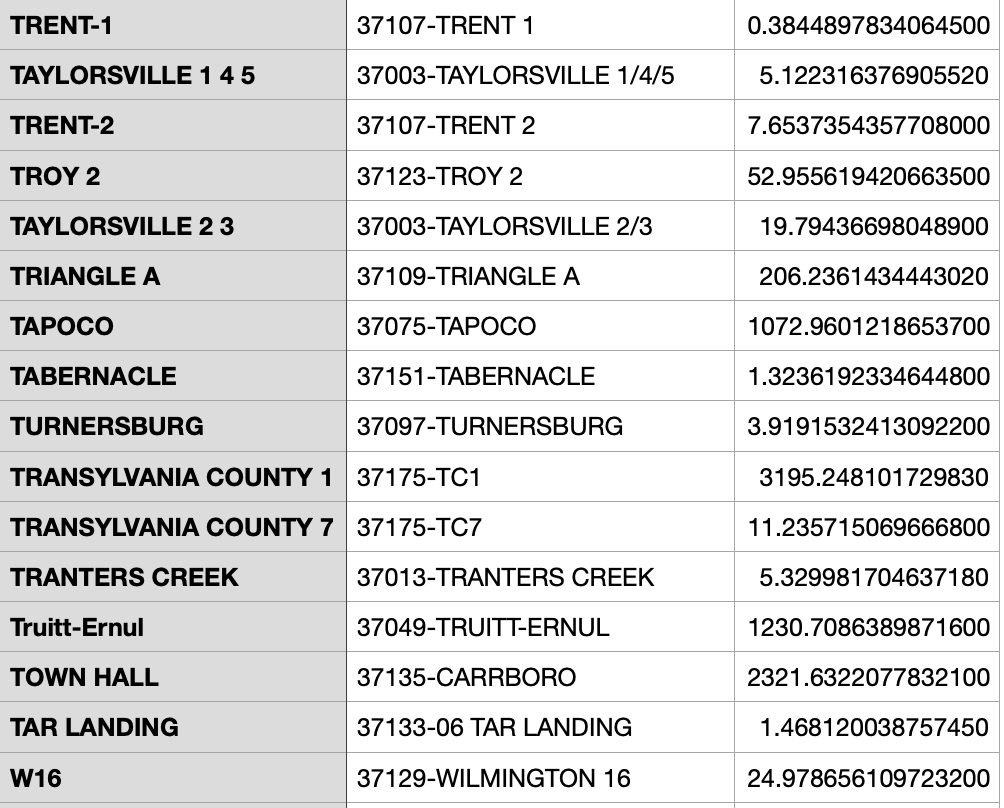

In [142]:
matches_df.shape

(2657, 5)

# 2. Dominant Precinct Assignment to State Legislative Districts

In [163]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# !pip install geojson

import geojson

<Axes: >

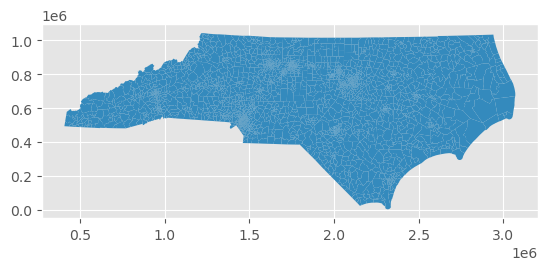

In [174]:
# load in precinct shapes
gdf_nc_precincts = gpd.read_file(ncsbe_input_path)

#I realized elsewhere that the combination of county_id and prec_id combine to form a unique precinct ID universal across NCSBE data
gdf_nc_precincts['unique_precinct_id'] = gdf_nc_precincts['county_id'].astype(str) +'-'+ gdf_nc_precincts['prec_id'].astype(str)

gdf_nc_precincts.plot()

In [175]:
gdf_nc_senate_path = 'data/geographies/original/tl_2023_37_sldu/tl_2023_37_sldu.shp'

gdf_nc_senate =  gpd.read_file(gdf_nc_senate_path)

In [176]:
# let's take a look to see what's in each of our geodataframes
gdf_nc_precincts.info()
gdf_nc_precincts.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2657 entries, 0 to 2656
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  2657 non-null   int64   
 1   prec_id             2657 non-null   object  
 2   enr_desc            2649 non-null   object  
 3   county_nam          2657 non-null   object  
 4   of_prec_id          2 non-null      object  
 5   county_id           2657 non-null   int64   
 6   geometry            2657 non-null   geometry
 7   unique_precinct_id  2657 non-null   object  
dtypes: geometry(1), int64(2), object(5)
memory usage: 166.2+ KB


,id,prec_id,enr_desc,county_nam,of_prec_id,county_id,geometry,unique_precinct_id
0,1,0003,ALBEMARLE NUMBER 3,STANLY,NaN,84,"POLYGON ((1644857.853 584760.831, 1644768.728 ...",84-0003
1,2,0003,DREXEL 03,BURKE,NaN,12,"POLYGON ((1220715.101 726879.358, 1220723.026 ...",12-0003
2,22,0019,LINVILLE 01,BURKE,NaN,12,"POLYGON ((1142032.036 735283.149, 1141893.094 ...",12-0019
3,23,0019,RIDENHOUR,STANLY,NaN,84,"POLYGON ((1590551.101 597789.851, 1590587.761 ...",84-0019
4,71,007,007,MECKLENBURG,NaN,60,"POLYGON ((1465943.013 524872.128, 1465762.759 ...",60-007


In [177]:
gdf_nc_senate.info()
gdf_nc_senate.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   50 non-null     object  
 1   SLDUST    50 non-null     object  
 2   GEOID     50 non-null     object  
 3   GEOIDFQ   50 non-null     object  
 4   NAMELSAD  50 non-null     object  
 5   LSAD      50 non-null     object  
 6   LSY       50 non-null     object  
 7   MTFCC     50 non-null     object  
 8   FUNCSTAT  50 non-null     object  
 9   ALAND     50 non-null     int64   
 10  AWATER    50 non-null     int64   
 11  INTPTLAT  50 non-null     object  
 12  INTPTLON  50 non-null     object  
 13  geometry  50 non-null     geometry
dtypes: geometry(1), int64(2), object(11)
memory usage: 5.6+ KB


,STATEFP,SLDUST,GEOID,GEOIDFQ,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,37,001,37001,610U800US37001,State Senate District 1,LU,2022,G5210,N,7337196471,8634304882,+35.4708260,-076.2280820,"POLYGON ((-77.16777 34.79100, -77.16772 34.791..."
1,37,045,37045,610U800US37045,State Senate District 45,LU,2022,G5210,N,1458893938,44980017,+35.7207490,-081.2800714,"POLYGON ((-81.59180 35.81549, -81.59177 35.815..."
2,37,002,37002,610U800US37002,State Senate District 2,LU,2022,G5210,N,5020420966,515666201,+35.3239689,-077.0768755,"POLYGON ((-77.83420 35.17889, -77.83415 35.179..."
3,37,046,37046,610U800US37046,State Senate District 46,LU,2022,G5210,N,3275977742,36637476,+35.7001279,-082.0008389,"POLYGON ((-82.60950 35.75606, -82.60941 35.756..."
4,37,003,37003,610U800US37003,State Senate District 3,LU,2022,G5210,N,11479387894,1634070383,+36.2159332,-076.9498283,"POLYGON ((-78.32399 36.54382, -78.31796 36.543..."


In [178]:
# As before, reproject to same coordinate system (32617 is Universal Transverse Mercator, UTM)
gdf_nc_precincts = gdf_nc_precincts.to_crs("EPSG:32617")
gdf_nc_senate = gdf_nc_senate.to_crs("EPSG:32617")

#Calculate areas of the geometries
gdf_nc_precincts['precinct_area'] = gdf_nc_precincts.geometry.area
gdf_nc_senate['district_area'] = gdf_nc_senate.geometry.area

#### The following code is to eliminate districts double-counting precincts. I had been using sjoins before, but figured out it's easier to use overlay to assign dominant precincts to districts

In [179]:
gdf_nc_precincts_senate = gpd.overlay(gdf_nc_senate, gdf_nc_precincts, how="intersection").reset_index()

In [180]:
gdf_nc_precincts_senate.info()
gdf_nc_precincts_senate.head()
unique_ids = gdf_nc_precincts_senate['unique_precinct_id'].nunique()
print(unique_ids)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3803 entries, 0 to 3802
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               3803 non-null   int64   
 1   STATEFP             3803 non-null   object  
 2   SLDUST              3803 non-null   object  
 3   GEOID               3803 non-null   object  
 4   GEOIDFQ             3803 non-null   object  
 5   NAMELSAD            3803 non-null   object  
 6   LSAD                3803 non-null   object  
 7   LSY                 3803 non-null   object  
 8   MTFCC               3803 non-null   object  
 9   FUNCSTAT            3803 non-null   object  
 10  ALAND               3803 non-null   int64   
 11  AWATER              3803 non-null   int64   
 12  INTPTLAT            3803 non-null   object  
 13  INTPTLON            3803 non-null   object  
 14  district_area       3803 non-null   float64 
 15  id                  3803 non-n

#### OK, so we can see that ~1150 precincts overlap between state legislative districts, time to assign dominant district

In [182]:
# Getting the intersection area

# First line gets the area of the geometry. By definition of the merge, this is the intersection
gdf_nc_precincts_senate['intersection_area'] = gdf_nc_precincts_senate.geometry.area

# We summarize the intersection area
gdf_nc_precincts_senate['intersection_area'].describe()

count    3.803000e+03
mean     3.668336e+07
std      6.870187e+07
min      4.919062e-11
25%      7.144280e+00
50%      7.130823e+06
75%      4.962397e+07
max      1.263169e+09
Name: intersection_area, dtype: float64

In [183]:
# The intersection ratio is the intersection area in the joined DF divided
# by the area of the precinct. This is how much of the precinct is captured
# in the intersection
gdf_nc_precincts_senate['intersection_ratio'] = gdf_nc_precincts_senate['intersection_area'] / gdf_nc_precincts_senate['precinct_area']

# The intersection ratio is pretty bimodally distributed, with a lot
# near 0 and a lot near 1
gdf_nc_precincts_senate['intersection_ratio'].describe()

count    3.803000e+03
mean     6.986590e-01
std      4.583819e-01
min      8.939477e-19
25%      2.447672e-07
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: intersection_ratio, dtype: float64

In [189]:
# Create a subset where the intersection ratio is high
# I chose 60% as the cutoff to capture all 2657 precincts but most of the precinct intersections have tiny overlap
gdf_nc_precincts_senate_subset = gdf_nc_precincts_senate[gdf_nc_precincts_senate['intersection_ratio'] >= 0.60]
gdf_nc_precincts_senate_subset.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2657 entries, 1 to 3802
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               2657 non-null   int64   
 1   STATEFP             2657 non-null   object  
 2   SLDUST              2657 non-null   object  
 3   GEOID               2657 non-null   object  
 4   GEOIDFQ             2657 non-null   object  
 5   NAMELSAD            2657 non-null   object  
 6   LSAD                2657 non-null   object  
 7   LSY                 2657 non-null   object  
 8   MTFCC               2657 non-null   object  
 9   FUNCSTAT            2657 non-null   object  
 10  ALAND               2657 non-null   int64   
 11  AWATER              2657 non-null   int64   
 12  INTPTLAT            2657 non-null   object  
 13  INTPTLON            2657 non-null   object  
 14  district_area       2657 non-null   float64 
 15  id                  2657 non-null  

## Re-project crs to have latitude and longitude, convert to well-known text, wkt, then save the subset as a shapefile (for tableau) and csv for BigQuery

In [194]:
ncsen_shapefile_output_path = "data/geographies/processed/ncsen_w_precincts/ncsen_w_precincts.shp"
ncsen_csv_output_path = 'data/geographies/processed/ncsen_w_precincts/ncsen_w_precincts.csv'

# Reproject to WGS 84
gdf_nc_precincts_senate_subset = gdf_nc_precincts_senate_subset.to_crs(epsg=4326)

# Convert geometries to WKT format for BigQuery compatibility
gdf_nc_precincts_senate_subset['geometry_wkt'] = gdf_nc_precincts_senate_subset['geometry'].apply(lambda x: x.wkt)

# load NYT GeoJSON file and filter for only NC using the state FIPS code (37)
gdf_nc_precincts_senate_subset.to_file(ncsen_shapefile_output_path)
gdf_nc_precincts_senate_subset.to_csv(ncsen_csv_output_path, index=False)

/var/folders/h4/j84n8y_50sq08cp7wghj5_xm0000gn/T/ipykernel_18083/3355446967.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nc_precincts_senate_subset.to_file(ncsen_shapefile_output_path)
